# Simple Transformer Model for a-z Character Generation

A simplified transformer implementation based for character-level text generation using only a-z vocabulary with block size of 8.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
import platform

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)

print("Python version      :", platform.python_version())
print("PyTorch version     :", torch.__version__)
print("CUDA (torch) version:", torch.version.cuda)
print("cuDNN version       :", torch.backends.cudnn.version())
print("CUDA available      :", torch.cuda.is_available())

print(f"PyTorch version: {torch.__version__}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Python version      : 3.12.6
PyTorch version     : 2.7.1+cpu
CUDA (torch) version: None
cuDNN version       : None
CUDA available      : False
PyTorch version: 2.7.1+cpu
Using device: cpu


``` text
================================================================================
                        SIMPLE TRANSFORMER MODEL ARCHITECTURE
                    Decoder-Only Autoregressive Text Generation
================================================================================

Model Configuration:
┌─────────────────────────────────────────────────────────────────────────────┐
│ Vocab Size: 28 (a-z + space + newline)  │  Context Length: 64 characters    │
│ Embedding Dim: 128                       │  Attention Heads: 8               │
│ Transformer Layers: 6                    │  Total Parameters: 1.2M           │
└─────────────────────────────────────────────────────────────────────────────┘

TRANSFORMER FLOW DIAGRAM:
═══════════════════════════

📝 INPUT TEXT
┌─────────────────────────────────────────────────────────────────────────────┐
│ Example: "dogs are loyal and friendly animals that make great pets"        │
│ ⚡ Max Context: 64 characters at once                                       │
└─────────────────────────────────────────────────────────────────────────────┘
                                    ↓

🔢 TOKENIZATION  
┌─────────────────────────────────────────────────────────────────────────────┐
│ Characters → Token IDs                                                      │
│ [3,14,6,18,26,0,17,4,26,11,14,24,0,11,...]                               │
└─────────────────────────────────────────────────────────────────────────────┘
                                    ↓

🎯 TOKEN EMBEDDING
┌─────────────────────────────────────────────────────────────────────────────┐
│ Token IDs → Dense Vectors (28 × 128)                                       │
│ token_emb = TokenEmbedding(token_ids)                                       │
└─────────────────────────────────────────────────────────────────────────────┘
                                    +

📍 POSITIONAL EMBEDDING
┌─────────────────────────────────────────────────────────────────────────────┐
│ Position indices → Dense Vectors (64 × 128)                                │
│ pos_emb = PositionalEmbedding(positions)                                    │
└─────────────────────────────────────────────────────────────────────────────┘
                                    ↓

➕ COMBINED EMBEDDINGS
┌─────────────────────────────────────────────────────────────────────────────┐
│ x = token_emb + pos_emb                                                     │
│ Shape: (batch_size, seq_len, 128)                                          │
└─────────────────────────────────────────────────────────────────────────────┘
                                    ↓

╔═════════════════════════════════════════════════════════════════════════════╗
║                        🔄 TRANSFORMER BLOCK × 6 LAYERS                       ║
╠═════════════════════════════════════════════════════════════════════════════╣
║                                                                             ║
║  ┌─────────────────────────────────────────────────────────────────────┐   ║
║  │                         LAYER NORM 1                                │   ║
║  │                Normalize input for attention                        │   ║
║  └─────────────────────────────────────────────────────────────────────┘   ║
║                                    ↓                                        ║
║  ┌─────────────────────────────────────────────────────────────────────┐   ║
║  │                 🎯 MULTI-HEAD ATTENTION (8 heads)                   │   ║
║  │                                                                     │   ║
║  │ • Q, K, V = Linear(x)                                               │   ║
║  │ • Attention = softmax(QK^T/√d_k)V                                   │   ║
║  │ • Head_size = 128/8 = 16                                            │   ║
║  │ • Attention_Matrix = 64×64 (context_length²)                       │   ║
║  │                                                                     │   ║
║  │ Features:                                                           │   ║
║  │ • Query, Key, Value projections                                     │   ║
║  │ • Scaled dot-product attention                                      │   ║
║  │ • Causal masking (64×64 lower triangular)                         │   ║
║  │ • Each position attends to ≤64 previous positions                  │   ║
║  │ • Concatenate & project heads                                       │   ║
║  └─────────────────────────────────────────────────────────────────────┘   ║
║                                    ↓                                        ║
║  ┌─────────────────────────────────────────────────────────────────────┐   ║
║  │                    ➕ RESIDUAL CONNECTION 1                          │   ║
║  │                    x = x + attention(norm(x))                       │   ║
║  └─────────────────────────────────────────────────────────────────────┘   ║
║                                    ↓                                        ║
║  ┌─────────────────────────────────────────────────────────────────────┐   ║
║  │                         LAYER NORM 2                                │   ║
║  │              Normalize input for feed-forward                       │   ║
║  └─────────────────────────────────────────────────────────────────────┘   ║
║                                    ↓                                        ║
║  ┌─────────────────────────────────────────────────────────────────────┐   ║
║  │                   🧠 FEED FORWARD NETWORK                           │   ║
║  │                                                                     │   ║
║  │ • FFN(x) = GELU(Linear1(x)) * Linear2                              │   ║
║  │ • Hidden_dim = 4 × 128 = 512                                       │   ║
║  │                                                                     │   ║
║  │ Architecture:                                                       │   ║
║  │ • Linear projection to 512 dims                                     │   ║
║  │ • GELU activation function                                          │   ║
║  │ • Linear projection back to 128 dims                               │   ║
║  │ • Dropout for regularization                                        │   ║
║  └─────────────────────────────────────────────────────────────────────┘   ║
║                                    ↓                                        ║
║  ┌─────────────────────────────────────────────────────────────────────┐   ║
║  │                    ➕ RESIDUAL CONNECTION 2                          │   ║
║  │                      x = x + ffn(norm(x))                          │   ║
║  └─────────────────────────────────────────────────────────────────────┘   ║
║                                                                             ║
╚═════════════════════════════════════════════════════════════════════════════╝
                                    ↓

📊 FINAL LAYER NORM
┌─────────────────────────────────────────────────────────────────────────────┐
│ Normalize final transformer output                                          │
└─────────────────────────────────────────────────────────────────────────────┘
                                    ↓

🎯 OUTPUT HEAD
┌─────────────────────────────────────────────────────────────────────────────┐
│ Linear projection to vocabulary size                                        │
│ logits = Linear(x) → (batch, seq_len, 28)                                  │
└─────────────────────────────────────────────────────────────────────────────┘
                                    ↓

📈 SOFTMAX & SAMPLING
┌─────────────────────────────────────────────────────────────────────────────┐
│ Convert logits to probabilities & sample next token                        │
│ probs = softmax(logits / temperature)                                       │
└─────────────────────────────────────────────────────────────────────────────┘
                                    ↓

📝 GENERATED TEXT
┌─────────────────────────────────────────────────────────────────────────────┐
│ Decode token IDs back to characters                                         │
│                                                                             │
│ Examples:                                                                   │
│ 🐕 "dogs" → "dogs come in many different breeds like gold"                │
│ 🐱 "cats" → "cats communicate through meowing purring and"                │
│ 🐘 "elephants" → "elephants live in family groups led by the oldest"     │
│ 🦇 "bats" → "bats hibernate during winter when insects ar"               │
└─────────────────────────────────────────────────────────────────────────────┘

```

## Setup Character Vocabulary and Data


In [2]:
# Create a-z vocabulary + space + newline
chars = [chr(i) for i in range(ord('a'), ord('z') + 1)]  # a-z
chars.append(' ')  # space
chars.append('\n')  # newline
vocab_size = len(chars)
print(f"Vocabulary: {chars}")
print(f"Vocabulary size: {vocab_size}")

# Create mappings
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

# Encoding and decoding functions
def encode(s):
    return [stoi[c] for c in s if c in stoi]

def decode(l):
    return ''.join([itos[i] for i in l])

# Test encoding/decoding
test_text = "hello\nworld"
encoded = encode(test_text)
decoded = decode(encoded)
print(f"Original: '{test_text}'")
print(f"Encoded: {encoded}")
print(f"Decoded: '{decoded}'")


Vocabulary: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '\n']
Vocabulary size: 28
Original: 'hello
world'
Encoded: [7, 4, 11, 11, 14, 27, 22, 14, 17, 11, 3]
Decoded: 'hello
world'


##  Load animal training data from file

In [3]:
# Load animal training data from file
with open('animal_training_data.txt', 'r', encoding='utf-8') as f:
    text = f.read().strip()
print("Successfully loaded animal training data!")

# Verify the text contains only a-z, space, and newline characters
allowed_chars = set(chars)
clean_text = ''.join([c.lower() if c.lower() in allowed_chars else '' for c in text])

print(f"Training text length: {len(clean_text)} characters")
print(f"First 200 characters: {repr(clean_text[:200])}")  # Use repr to show newlines
print(f"Last 100 characters: ...{repr(clean_text[-100:])}")

# Store as text variable for compatibility
text = clean_text


Successfully loaded animal training data!
Training text length: 32509 characters
First 200 characters: 'dogs are loyal and friendly animals that make great pets for families with children dogs love to play fetch and go for walks in the park dogs need daily exercise and proper nutrition to stay healthy d'
Last 100 characters: ...'zing geese play important roles in many ecosystems and have been domesticated for thousands of years'


## Model Configuration


In [4]:
@dataclass
class ModelConfig:
    vocab_size: int = 28  # a-z + space + newline
    block_size: int = 64   # context length
    n_embd: int = 128      # embedding dimension
    n_head: int = 8       # number of attention heads
    n_layer: int = 6      # number of transformer blocks
    dropout: float = 0.1  # dropout rate

config = ModelConfig()
print(f"Model configuration:")
print(f"  Vocabulary size: {config.vocab_size}")
print(f"  Block size: {config.block_size}")
print(f"  Embedding dimension: {config.n_embd}")
print(f"  Number of heads: {config.n_head}")
print(f"  Number of layers: {config.n_layer}")
print(f"  Dropout: {config.dropout}")


Model configuration:
  Vocabulary size: 28
  Block size: 64
  Embedding dimension: 128
  Number of heads: 8
  Number of layers: 6
  Dropout: 0.1


## Transformer Components


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_size = config.n_embd // config.n_head
        
        # Query, Key, Value projections
        self.qkv = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)
        
        # Causal mask
        self.register_buffer(
            "mask", 
            torch.tril(torch.ones(config.block_size, config.block_size))
            .view(1, 1, config.block_size, config.block_size)
        )
    
    def forward(self, x):
        B, T, C = x.size()  # batch, time, channels
        
        # Calculate Q, K, V
        qkv = self.qkv(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        
        # Reshape for multi-head attention
        q = q.view(B, T, self.n_head, self.head_size).transpose(1, 2)  # (B, nh, T, hs)
        k = k.view(B, T, self.n_head, self.head_size).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, self.head_size).transpose(1, 2)  # (B, nh, T, hs)
        
        # Attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_size))
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)
        
        # Apply attention to values
        y = att @ v  # (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # Reassemble heads
        
        # Output projection
        y = self.proj(y)
        return y


class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )
    
    def forward(self, x):
        return self.net(x)


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.ffn = FeedForward(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

print("Transformer components defined successfully!")


Transformer components defined successfully!


### Alternative

### Flash attentions - increase FLOPS but reduce memory accesss
output = F.scaled_dot_product_attention(q, k, v, attn_mask=mask, dropout_p=0.1)

### Using Multiple AttentionHead
```python
class AttentionHead(nn.Module):
    """Single attention head with separate Q, K, V projections"""
    def __init__(self, config):
        super().__init__()
        self.head_size = config.n_embd // config.n_head
        
        # Separate Q, K, V projections instead of combined QKV
        self.q_proj = nn.Linear(config.n_embd, self.head_size, bias=False)
        self.k_proj = nn.Linear(config.n_embd, self.head_size, bias=False)  
        self.v_proj = nn.Linear(config.n_embd, self.head_size, bias=False)
        
        self.dropout = nn.Dropout(config.dropout)
        
        # Causal mask
        self.register_buffer(
            "mask", 
            torch.tril(torch.ones(config.block_size, config.block_size))
        )
    
    def forward(self, x):
        B, T, C = x.size()
        
        # Separate Q, K, V projections
        q = self.q_proj(x)  # (B, T, head_size)
        k = self.k_proj(x)  # (B, T, head_size) 
        v = self.v_proj(x)  # (B, T, head_size)
        
        # Attention computation
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_size))
        att = att.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)
        
        # Apply attention to values
        out = att @ v  # (B, T, head_size)
        return out


class MultiHeadAttention(nn.Module):
    """Multi-head attention using separate AttentionHead instances"""
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_size = config.n_embd // config.n_head
        
        # Create separate attention heads
        self.heads = nn.ModuleList([
            AttentionHead(config) for _ in range(config.n_head)
        ])
        
        # Output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, x):
        # Run each head separately and concatenate results
        head_outputs = [head(x) for head in self.heads]
        out = torch.cat(head_outputs, dim=-1)  # (B, T, n_embd)
        
        # Output projection
        out = self.proj(out)
        return out

```

## Simple Transformer Model


In [6]:
class SimpleTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Token and position embeddings
        self.token_embedding = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_embedding = nn.Embedding(config.block_size, config.n_embd)
        
        # Transformer blocks
        self.blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config.n_layer)]
        )
        
        # Final layer norm and output head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):
        B, T = idx.size()
        assert T <= self.config.block_size, f"Sequence too long: {T} > {self.config.block_size}"
        
        # Create position indices
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        
        # Embeddings
        tok_emb = self.token_embedding(idx)  # (B, T, n_embd)
        pos_emb = self.position_embedding(pos)  # (T, n_embd)
        x = tok_emb + pos_emb  # (B, T, n_embd)
        
        # Transformer blocks
        x = self.blocks(x)
        x = self.ln_f(x)
        
        # Get logits
        logits = self.head(x)  # (B, T, vocab_size)
        
        # Calculate loss if targets provided
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1.0):
        """
        Generate new tokens given a context
        """
        self.eval()
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Crop context if too long
                idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
                
                # Get predictions
                logits, _ = self(idx_cond)
                logits = logits[:, -1, :] / temperature  # Get last token and scale
                
                # Sample from distribution
                probs = F.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
                
                # Append to sequence
                idx = torch.cat((idx, idx_next), dim=1)
        
        self.train()
        return idx

# Create model
model = SimpleTransformer(config).to(device)

# Count parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"Model created with {n_params:,} parameters")
print(f"Model size: {n_params * 4 / 1024 / 1024:.2f} MB (fp32)")


Model created with 1,205,276 parameters
Model size: 4.60 MB (fp32)


## Data Preparation


In [7]:
def get_batch(data, block_size, batch_size):
    """
    Generate a batch of input-target pairs
    """
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# Prepare training data
# Clean text to only include a-z, spaces, and newlines
clean_text = ''.join([c.lower() if c.lower() in chars else '' for c in text])
print(f"Clean text length: {len(clean_text)} characters")
print(f"Sample: {repr(clean_text[:150])}")  # Use repr to show newlines

# Verify vocabulary is complete
print(f"Current vocabulary size: {len(chars)}")
print(f"Vocabulary: {chars}")

# Update config with actual vocabulary size
config.vocab_size = len(chars)
print(f"Updated config vocabulary size: {config.vocab_size}")

# Encode the text
data = torch.tensor(encode(clean_text), dtype=torch.long)
print(f"Data tensor shape: {data.shape}")

# Split into train/val
n = len(data)
train_data = data[:int(0.9*n)]
val_data = data[int(0.9*n):]
print(f"Train data: {len(train_data)} tokens")
print(f"Val data: {len(val_data)} tokens")

# Test batch generation
batch_size = 4
x, y = get_batch(train_data, config.block_size, batch_size)
print(f"\nBatch shapes: x={x.shape}, y={y.shape}")
print(f"Sample input: {repr(decode(x[0].tolist()))}")
print(f"Sample target: {repr(decode(y[0].tolist()))}")


Clean text length: 32509 characters
Sample: 'dogs are loyal and friendly animals that make great pets for families with children dogs love to play fetch and go for walks in the park dogs need dai'
Current vocabulary size: 28
Vocabulary: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '\n']
Updated config vocabulary size: 28
Data tensor shape: torch.Size([32509])
Train data: 29258 tokens
Val data: 3251 tokens

Batch shapes: x=torch.Size([4, 64]), y=torch.Size([4, 64])
Sample input: 'eat and humidity and can overheat easily\n\nguinea pigs are small '
Sample target: 'at and humidity and can overheat easily\n\nguinea pigs are small d'


## Training


In [8]:
# Recreate model with updated config
model = SimpleTransformer(config).to(device)
n_params = sum(p.numel() for p in model.parameters())
print(f"Model recreated with {n_params:,} parameters")

# Training parameters
learning_rate = 3e-4
max_iters = 10000
eval_interval = 500
batch_size = 32

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
losses = []
model.train()

print("Starting training...")
for iter in range(max_iters):
    # Get batch
    x, y = get_batch(train_data, config.block_size, batch_size)
    
    # Forward pass
    logits, loss = model(x, y)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Track loss
    losses.append(loss.item())
    
    # Print progress
    if iter % eval_interval == 0 or iter == max_iters - 1:
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_losses = []
            for _ in range(100):  # 100 validation batches
                x_val, y_val = get_batch(val_data, config.block_size, batch_size)
                _, val_loss = model(x_val, y_val)
                val_losses.append(val_loss.item())
            val_loss = sum(val_losses) / len(val_losses)
        
        model.train()
        print(f"iter {iter:4d}: train loss {loss.item():.4f}, val loss {val_loss:.4f}")

print("Training completed!")


Model recreated with 1,205,276 parameters
Starting training...
iter    0: train loss 3.3642, val loss 3.1454
iter  500: train loss 1.9557, val loss 1.9224
iter 1000: train loss 1.2998, val loss 1.5871
iter 1500: train loss 0.8808, val loss 1.5984
iter 2000: train loss 0.6244, val loss 1.8584
iter 2500: train loss 0.3946, val loss 2.0702
iter 3000: train loss 0.3073, val loss 2.2184
iter 3500: train loss 0.2929, val loss 2.4073
iter 4000: train loss 0.2762, val loss 2.4973
iter 4500: train loss 0.2370, val loss 2.6265
iter 5000: train loss 0.2220, val loss 2.6438
iter 5500: train loss 0.2147, val loss 2.6428
iter 6000: train loss 0.2248, val loss 2.7149
iter 6500: train loss 0.2120, val loss 2.7548
iter 7000: train loss 0.1950, val loss 2.8730
iter 7500: train loss 0.2074, val loss 2.8275
iter 8000: train loss 0.2005, val loss 2.9106
iter 8500: train loss 0.1908, val loss 2.9102
iter 9000: train loss 0.1730, val loss 2.9331
iter 9500: train loss 0.1891, val loss 2.9842
iter 9999: train 

## Visualize Training


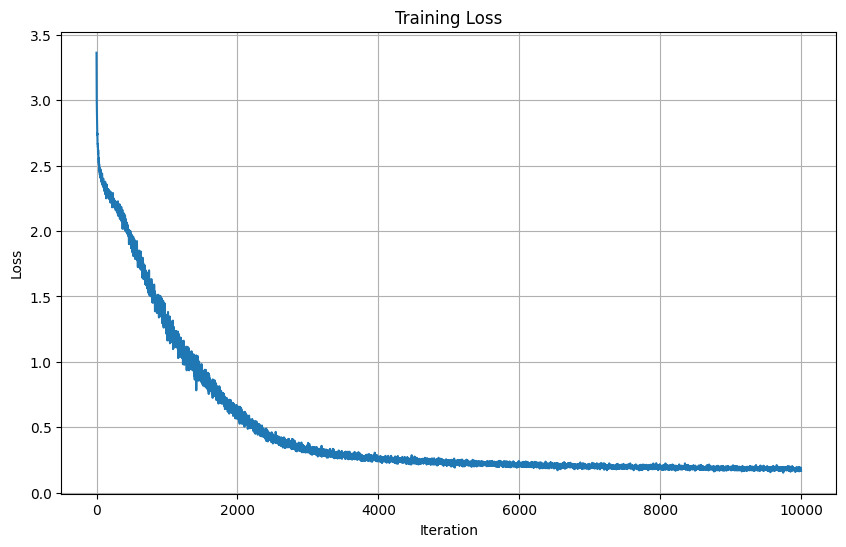

Final training loss: 0.1662


In [9]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Show final loss
print(f"Final training loss: {losses[-1]:.4f}")


## Text Generation


In [10]:
def generate_text(prompt, max_tokens=50, temperature=1.0):
    """
    Generate text given a prompt
    """
    # Encode prompt
    prompt_encoded = encode(prompt.lower())
    if len(prompt_encoded) == 0:
        prompt_encoded = [0]  # Start with first character if empty
    
    # Convert to tensor
    context = torch.tensor(prompt_encoded, dtype=torch.long, device=device).unsqueeze(0)
    
    # Generate
    generated = model.generate(context, max_tokens, temperature)
    
    # Decode
    return decode(generated[0].tolist())

# Test generation with different animal-related prompts
prompts = ["dogs", "cats", "birds", "fish", "elephants","bats","bats","geese","geese"]

print("Animal Text Generation Examples:")
print("=" * 50)

for prompt in prompts:
    generated = generate_text(prompt, max_tokens=40, temperature=0.8)
    print(f"Prompt: '{prompt}'")
    print(f"Generated: '{generated}'")
    print("-" * 30)

# Try different temperatures with animal prompt
print("\nSame prompt with different temperatures:")
print("=" * 50)
prompt = "dogs are"
for temp in [0.5, 1.0, 1.5]:
    generated = generate_text(prompt, max_tokens=30, temperature=temp)
    print(f"Temperature {temp}: '{generated}'")


Animal Text Generation Examples:
Prompt: 'dogs'
Generated: 'dogs love to play fetch and go for walks in '
------------------------------
Prompt: 'cats'
Generated: 'cats live in highly organized colonies with '
------------------------------
Prompt: 'birds'
Generated: 'birds use their tongues to smell and taste th'
------------------------------
Prompt: 'fish'
Generated: 'fish crabs mollusks and other aquatic creatu'
------------------------------
Prompt: 'elephants'
Generated: 'elephants have large ears that help them cool dow'
------------------------------
Prompt: 'bats'
Generated: 'bats live in colonies that can contain milli'
------------------------------
Prompt: 'bats'
Generated: 'bats are wild canines that are ancestors of '
------------------------------
Prompt: 'geese'
Generated: 'geese sharks have multiple rows of sharp teet'
------------------------------
Prompt: 'geese'
Generated: 'geese and can overheat easily

guinea pigs ar'
------------------------------

Same prompt wi

## Model Analysis


In [11]:
# Analyze model components
print("Model Architecture:")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Embedding parameters: {model.token_embedding.weight.numel() + model.position_embedding.weight.numel():,}")
print(f"  Transformer parameters: {sum(p.numel() for p in model.blocks.parameters()):,}")
print(f"  Output head parameters: {model.head.weight.numel():,}")

# Test model on sample animal-related input
sample_input = "dogs are"
encoded_input = torch.tensor(encode(sample_input), dtype=torch.long, device=device).unsqueeze(0)

model.eval()
with torch.no_grad():
    logits, _ = model(encoded_input)
    probs = F.softmax(logits[0, -1], dim=-1)
    
print(f"\nNext character probabilities for '{sample_input}':")
top_k = 8
top_probs, top_indices = torch.topk(probs, top_k)
for i in range(top_k):
    char = itos[top_indices[i].item()]
    prob = top_probs[i].item()
    print(f"  '{char}': {prob:.3f}")

model.train()


Model Architecture:
  Total parameters: 1,205,276
  Embedding parameters: 11,776
  Transformer parameters: 1,189,632
  Output head parameters: 3,584

Next character probabilities for 'dogs are':
  ' ': 1.000
  'x': 0.000
  'a': 0.000
  't': 0.000
  'i': 0.000
  'u': 0.000
  'o': 0.000
  '
': 0.000


SimpleTransformer(
  (token_embedding): Embedding(28, 128)
  (position_embedding): Embedding(64, 128)
  (blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=128, out_features=384, bias=True)
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=128, out_features=384, bi